In [25]:
#autoreload
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('../')
import torch
import numpy as np

import dataset
import json

from pl_model import SegmentadorMonoclase
import os
from glob import glob
import matplotlib.pyplot as plt
import math
from matplotlib.backends.backend_pdf import PdfPages

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# json_normalizacion="../modelos/normalization_rayosX.json"
# # Read json normalization file
# with open(json_normalizacion, 'r') as file:
#     normalizacion = json.load(file)


# media= normalizacion["medias_norm"]
# dstd= normalizacion["stds_norm"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
# def normalizacion_imagen(imgtensor,normalizacion):
#     media=torch.tensor(normalizacion['medias_norm']).unsqueeze(1).unsqueeze(2)
#     dstd=torch.tensor(normalizacion['stds_norm']).unsqueeze(1).unsqueeze(2)
#     imgnormalizado =(imgtensor-media)
#     return imgnormalizado

def predict_image(imgname,modelo,device):
    if isinstance(imgname,str):
        imgtensor = dataset.read_image_rayosX(imgname,2**16-1)
    else:
        imgtensor=imgname
    
    imgnormalizado=imgtensor # torch.log(imgtensor)/math.log(0.2)
    imgnormalizado=imgnormalizado.unsqueeze(0).to(device)
   
    modelo.eval()
    with torch.no_grad():
         logits = modelo(imgnormalizado)
    logits= logits[0,0,:,:]
    probs=torch.nn.functional.sigmoid(logits)
    probs=probs.cpu().numpy()         
    return probs

In [12]:
modelo= SegmentadorMonoclase(
                            optimizer = 'sgd',  
                            num_channels_in=3,
                            model_version="deeplabv3_resnet50",
                            p_dropout=0.5,
                          )
fichmodelo="../out_models/segmentadorRayosXmonocanal_sinlogaritmo.ckpt"
checkpoint = torch.load(fichmodelo)
modelo.load_state_dict(checkpoint['state_dict'])
modelo.eval()
_=modelo.to(device)


SegmentadorMonoclase Num epochs: None
MODEL NUM CHHANELS IN 3
DeepLab Num channels_in: 3


In [13]:
usuario=os.getenv('USER')
home=os.getenv('HOME')
mscanData= home + '/owc/mscanData/' if usuario == 'aalbiol' else home + 'mscanData/'
# /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales
dir_recortes_in=os.path.join(mscanData , 'rayosX/reales2/recortes_reales')
print(dir_recortes_in)
input_files=glob(os.path.join(dir_recortes_in , '*.png'))
print('Number of input files:', len(input_files))   
print('First file:', input_files[0])

/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales
Number of input files: 153
First file: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00135.png


In [14]:
root_folder="/home/aalbiol/owc/mscanData/rayosX/pollo"
train_dataset=("../listas_rayosX/buenos/train/train_list.txt","recortes_good")

params={
    'prob_no_change':0.0,
    'min_number_of_defects':1,
    'max_number_of_defects':5,
    'alpha_low': 0.02,
    'alpha_high': 0.04,
    'min_defect_size':40,
    'max_defect_size':150,
    'min_defect_width':2,
    'max_defect_width':5,
    'defect_types':{'FlatLine': 1.0, 'CylLine': 1.0, 'FlatSpline': 1.0, 'CylSpline':1.0}
    }

ds=dataset.DataplacesDataSetSimulaDefectos(root_folder=root_folder,dataplaces=[train_dataset], 
                             max_values=[2**16-1,2**16-1,2**16-1],delimiter=".",terminaciones=[".png"],
                             params_simulacion_defectos=params,transform=None,scale=1.0,monocanal=True,logaritmo=False)

>>>>>>>>>>>> DataplacesDataset terminaciones ['.png'] delimiter .
>>>>>>>>>> scale in DataSet 1.0
Datos de normalizacion calculados y guardados en modelos/normalization.json


['/home/aalbiol/owc/mscanData/rayosX/pollo/recortes_good/LOWentremusloGood_00085.png']


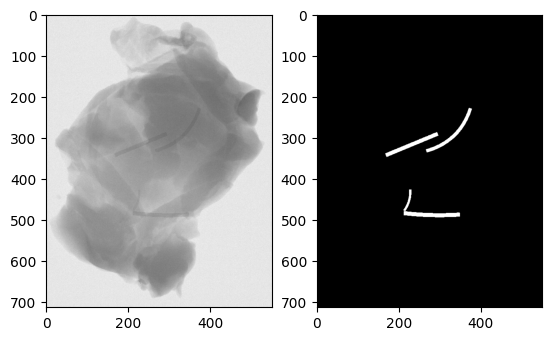

In [15]:
im,nombre,mask=ds.__getitem__(0)
print(nombre)
_=plt.subplot(1,2,1)
_=plt.imshow(im.permute((1,2,0)).numpy(),cmap="gray",clim=[0,1])
_=plt.subplot(1,2,2)
_=plt.imshow(mask.numpy(),cmap="gray",clim=[0,1])


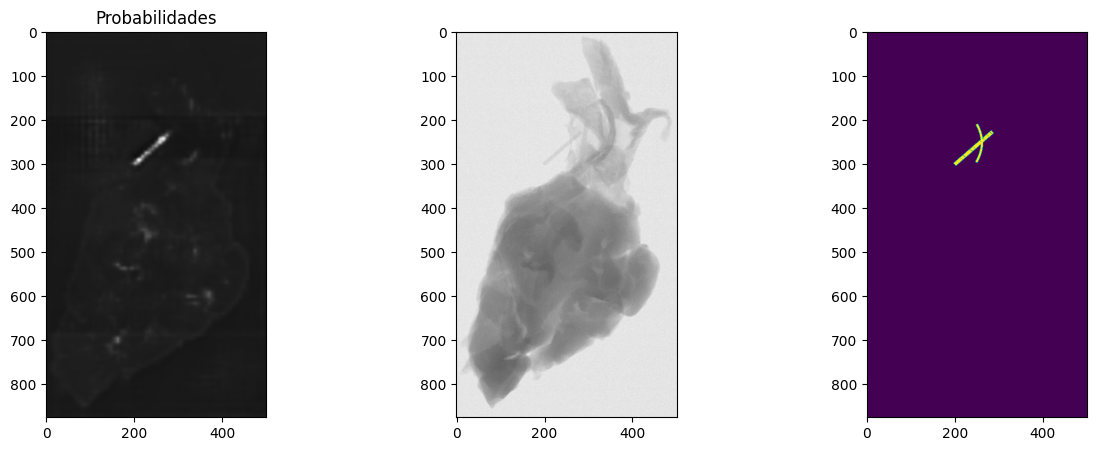

In [16]:
k=2
im,nombre,mask=ds.__getitem__(k)
probs=predict_image(im,modelo,device)
_=plt.figure(figsize=(15,5))
_=plt.subplot(1,3,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,3,2)
plt.imshow(im.permute((1,2,0)).numpy())
_=plt.subplot(1,3,3)
plt.imshow(mask.numpy())


# Defectos reales

In [20]:
input_files
numeros=[int(os.path.basename(f).split('_')[-1].replace(".png","")) for f in input_files]
numeros

[135,
 12,
 35,
 71,
 141,
 39,
 75,
 98,
 122,
 90,
 147,
 16,
 105,
 87,
 14,
 78,
 38,
 91,
 149,
 36,
 140,
 145,
 27,
 81,
 85,
 124,
 76,
 86,
 133,
 115,
 111,
 104,
 137,
 50,
 102,
 120,
 151,
 109,
 53,
 84,
 42,
 121,
 63,
 103,
 126,
 34,
 96,
 11,
 22,
 123,
 61,
 83,
 144,
 128,
 64,
 21,
 142,
 101,
 127,
 3,
 73,
 9,
 69,
 125,
 66,
 62,
 131,
 60,
 150,
 119,
 17,
 29,
 138,
 70,
 2,
 67,
 100,
 106,
 49,
 6,
 99,
 37,
 32,
 79,
 55,
 82,
 30,
 48,
 23,
 7,
 24,
 47,
 13,
 15,
 51,
 117,
 41,
 153,
 114,
 18,
 59,
 72,
 136,
 40,
 134,
 19,
 110,
 132,
 46,
 4,
 28,
 152,
 107,
 65,
 97,
 88,
 94,
 130,
 116,
 95,
 56,
 108,
 5,
 31,
 1,
 148,
 146,
 139,
 33,
 113,
 129,
 57,
 80,
 26,
 112,
 10,
 77,
 8,
 118,
 45,
 58,
 143,
 43,
 74,
 20,
 25,
 89,
 92,
 44,
 54,
 68,
 52,
 93]

Falsos Positivos Reales:
10, 35, 36_arriba, 38, 40, 44, 45, 46, 47, 48, 49, 51

52, 53, 54, 55, 57_arriba, 58, 59, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 79, 80_arriba,

81, 82, 83, 84, 85_arriba, 86, 87, 88, 93,95, 97, 98, 100,101, 103_abajo, 105, 107, 108, 111, 113_abajo, 115, 125, 127, 131, 135, 140, 141, 145

In [22]:
falsos_positivos=[0, 35, 36, 38, 40, 44, 45, 46, 47, 48, 49, 51,

52, 53, 54, 55, 57, 58, 59, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 79, 80,

81, 82, 83, 84, 85, 86, 87, 88, 93,

95, 97, 98, 100,

101, 103, 105, 107, 108, 111, 113, 115, 125, 127, 131, 135, 140, 141, 145]

verdaderos_positivos=[]

for file in input_files:
    numero=int(os.path.basename(file).split('_')[-1].replace(".png",""))
    if numero in falsos_positivos:
        print('Falso positivo:',file)
    else:
        print('Verdadero positivo:',file)
        verdaderos_positivos.append(file)

Falso positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00135.png
Verdadero positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00012.png
Falso positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00035.png
Verdadero positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00071.png
Falso positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00141.png
Verdadero positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00039.png
Falso positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00075.png
Falso positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00098.png
Verdadero positivo: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00122.png
Verdadero po

In [23]:
condefectos=verdaderos_positivos
print(condefectos)

['/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00012.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00071.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00039.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00122.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00090.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00147.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00016.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00014.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00078.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00091.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recor

torch.Size([3, 765, 444])


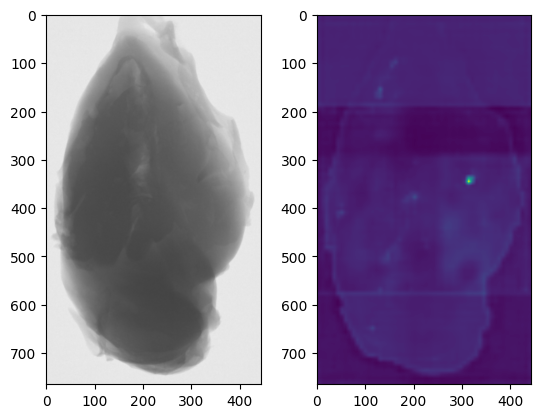

In [24]:
k=2
imlineal=dataset.read_image_rayosX(condefectos[k],2**16-1)
#Convertir a monocanal
imlineal=torch.mean(imlineal,dim=0,keepdim=True)
imlineal=torch.concat([imlineal]*3,dim=0)
print(imlineal.shape)
imgtensor=imlineal
probs=predict_image(imgtensor,modelo,device)
_=plt.subplot(1,2,1)
_= plt.imshow(imgtensor.permute((1,2,0)).detach().cpu().numpy())
_=plt.subplot(1,2,2)
img= plt.imshow(probs)

In [26]:
from tqdm import tqdm
with PdfPages('pdfs/reales_60_epochs.pdf') as pdf:
    for k in tqdm(range(0,len(condefectos))):
        imlineal=dataset.read_image_rayosX(condefectos[k],2**16-1)
        #Convertir a monocanal
        imlineal=torch.mean(imlineal,dim=0,keepdim=True)
        imlineal=torch.concat([imlineal]*3,dim=0)
        #print(imlineal.shape)
        imgtensor=imlineal
        probs=predict_image(imgtensor,modelo,device)
        bn=os.path.basename(condefectos[k])
        _=plt.figure(figsize=(15,10))
        _=plt.subplot(1,2,1)
        _= plt.imshow(imgtensor.permute((1,2,0)).detach().cpu().numpy())
        _=plt.title(bn)
        _=plt.subplot(1,2,2)
        _= plt.imshow(probs,clim=(0,1),cmap='gray')
        fig = plt.gcf()
        pdf.savefig(fig)
        plt.close(fig)



  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:13<00:00,  6.92it/s]
